## Part1: Text Processing and Exploratory Data Analysis

In [1]:
import csv
import datetime
import json
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from collections import Counter

In [2]:
# Function to normalize the data
def build_terms(line):

    filtered_line = line.lower() ## Transform in lowercase
    filtered_line = filtered_line.split() ## Tokenize the text to get a list of terms
    filtered_line = [re.sub(r'[^\w\s]', '', word) for word in filtered_line] # Removing non-words and non-whitespaces
    
    # Removing stop words
    stop_words = set(stopwords.words("english"))
    filtered_line = [word for word in filtered_line if word not in stop_words]  ## Eliminate the stopwords 

    # Stemming
    stemmer = PorterStemmer()
    filtered_line = [stemmer.stem(word) for word in filtered_line] ## Perform stemming
    
    # Joining the processed tokens back into a string
    processed_line = ' '.join(filtered_line)

    # Remove double whitespaces
    processed_line = re.sub(" {2,}", " ", processed_line)
    processed_line = re.sub(" +\n", "\n", processed_line).strip()    

    return processed_line

In [3]:
# Function to remove the emoticons
def remove_emoticons(text):
    # Define a pattern to find all the emoticons
    emoticon_pattern = re.compile("[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" 
                                  u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF" 
                                  u"\U00002500-\U00002BEF" u"\U00002702-\U000027B0" 
                                  u"\U000024C2-\U0001F251" u"\U0001f926-\U0001f937" 
                                  u"\U00010000-\U0010ffff" u"\u2640-\u2642" 
                                  u"\u2600-\u2B55" u"\u200d" 
                                  u"\u23cf" u"\u23e9" 
                                  u"\u231a" u"\ufe0f" 
                                  u"\u3030" "]+", re.UNICODE)

    # Replace emoticons with an empty string
    text_without_emoticons = emoticon_pattern.sub('', text)

    return str(text_without_emoticons)

In [4]:
# Function to remove the links
def remove_links(text):
    # Define a pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Replace URLs with an empty string
    text_without_links = url_pattern.sub('', text)

    return str(text_without_links)

In [5]:
# Function for entity recognition
nlp = spacy.load("en_core_web_sm") # Load the spaCy English language model for entity recognition
def extract_entities(text):
    doc = nlp(text) # Process the text using spaCy to obtain a Doc object
    entities = [(ent.text, ent.label_) for ent in doc.ents] # Extract entities from the Doc object and store them as tuples (text, label)
    return entities

# PRE-PROCESS OF THE DOCUMENT

In [8]:
# Load the JSON data
with open('IRWA_data_2023/Rus_Ukr_war_data.json', 'r') as file:
    tweet_information = {}
    tweet_times = []

    for line in file:
        tweet_data = json.loads(line)

        # Clean the text
        tweet_text = tweet_data['full_text']
        tweet_text = remove_emoticons(tweet_text)
        tweet_text = remove_links(tweet_text)

        # Extract relevant information
        tweet_id = tweet_data['id_str']
        tweet_date = tweet_data['created_at']
        tweet_times.append(datetime.datetime.strptime(tweet_date, '%a %b %d %H:%M:%S %z %Y'))
        hashtags = [hashtag['text'] for hashtag in tweet_data['entities']['hashtags']]
        likes = tweet_data['favorite_count']
        retweets = tweet_data['retweet_count'] 
        twitter_username = tweet_data['user']['screen_name']
        tweet_url = f"https://twitter.com/{twitter_username}/status/{tweet_id}"

        processed_tweet = build_terms(tweet_text)

        # Entity recognition
        entities = extract_entities(processed_tweet)

        # Store all the tweet information
        tweet_information[tweet_id] = {
            'Tweet ID': tweet_id,
            'Tweet Text': tweet_text,
            'Processed Tweet': processed_tweet,
            'Tweet Date': tweet_date,
            'Hashtags': hashtags,
            'Likes': likes,
            'Retweets': retweets,
            'Tweet_url': tweet_url,
            'Entities': entities
        }

# Map tweet IDs with document IDs for evaluation stage
tweet_document_ids_map = {}
with open('IRWA_data_2023/Rus_Ukr_war_data_ids.csv', 'r') as map_file:
    doc = csv.reader(map_file, delimiter='\t')
    for row in doc:
        doc_id, tweet_id = row
        tweet_document_ids_map[tweet_id] = doc_id

# EXPLORATORY DATA ANALYSIS

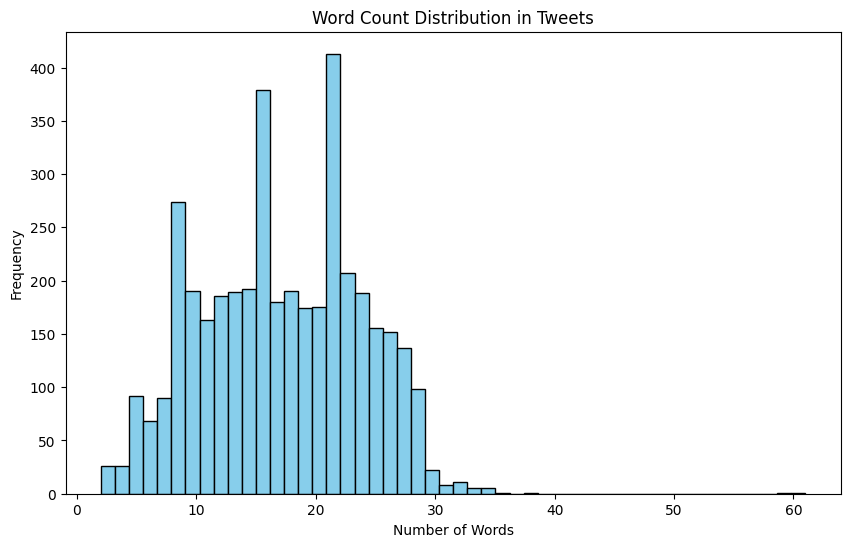

In [9]:
## Extract the number of words per tweet
num_words_tweet = [len(tweet_info['Processed Tweet'].split()) for tweet_info in tweet_information.values()]

# Plotting the number of words per tweet distribution
plt.figure(figsize=(10, 6))
plt.hist(num_words_tweet, bins=50, color='skyblue', edgecolor='black')
plt.title('Word Count Distribution in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [10]:
## Calculate average sentence length
total_sentences = sum(len(tweet_info['Tweet Text'].split('.')) for tweet_info in tweet_information.values())
average_sentence_length = total_sentences / len(tweet_information)

print(f'Average Sentence Length: {average_sentence_length:.2f} sentences \n')

Average Sentence Length: 2.01 sentences 



In [11]:
## Extract unique words from all tweets 
all_words = ' '.join(tweet_info['Processed Tweet'] for tweet_info in tweet_information.values())
unique_words = set(all_words.split())

print(f'Vocabulary Size: {len(unique_words)} words \n')

Vocabulary Size: 8207 words 



In [12]:
## Display top 5 most retweeted tweets
top_retweets = sorted(tweet_information.values(), key=lambda x: x['Retweets'], reverse=True)[:5]

for idx, tweet_info in enumerate(top_retweets, 1):
    print(f"Top {idx} Retweeted Tweet:")
    print(f"Tweet ID: {tweet_info['Tweet ID']}")
    print(f"Retweets: {tweet_info['Retweets']}")
    print(f"Processed Tweet: {tweet_info['Processed Tweet']}\n")

Top 1 Retweeted Tweet:
Tweet ID: 1575775162674212865
Retweets: 646
Processed Tweet: situat around lyman sep 30 1100 ua forc liber yampil advanc north ru troop reportedli abandon posit drobyshev exit rout lyman within fire rang ua forc ukrainerussiawar

Top 2 Retweeted Tweet:
Tweet ID: 1575396903252025351
Retweets: 338
Processed Tweet: uniqu rare photo ukrainian forward command post offens kharkiv oblast news report arent usual invit place seem except ukrainerussiawar

Top 3 Retweeted Tweet:
Tweet ID: 1575181552170201088
Retweets: 283
Processed Tweet: oper interflex ukrainian recruit continu master skill guidanc british canadian instructor uk ukrainerussiawar

Top 4 Retweeted Tweet:
Tweet ID: 1575625313446289409
Retweets: 251
Processed Tweet: follow countri urg citizen leav updat govern make similar statement ukrainerussiawar annexationofukrain nafo poland estonia latvia itali unit state bulgaria romania taiwan canada portug

Top 5 Retweeted Tweet:
Tweet ID: 1575742923068813314
Retweets

In [13]:
## Display top 5 most liked tweets
top_retweets = sorted(tweet_information.values(), key=lambda x: x['Likes'], reverse=True)[:5]

for idx, tweet_info in enumerate(top_retweets, 1):
    print(f"Top {idx} Liked Tweet:")
    print(f"Tweet ID: {tweet_info['Tweet ID']}")
    print(f"Likes: {tweet_info['Likes']}")
    print(f"Processed Tweet: {tweet_info['Processed Tweet']}\n")

Top 1 Liked Tweet:
Tweet ID: 1575775162674212865
Likes: 3701
Processed Tweet: situat around lyman sep 30 1100 ua forc liber yampil advanc north ru troop reportedli abandon posit drobyshev exit rout lyman within fire rang ua forc ukrainerussiawar

Top 2 Liked Tweet:
Tweet ID: 1575396903252025351
Likes: 2685
Processed Tweet: uniqu rare photo ukrainian forward command post offens kharkiv oblast news report arent usual invit place seem except ukrainerussiawar

Top 3 Liked Tweet:
Tweet ID: 1575181552170201088
Likes: 2155
Processed Tweet: oper interflex ukrainian recruit continu master skill guidanc british canadian instructor uk ukrainerussiawar

Top 4 Liked Tweet:
Tweet ID: 1575391586422243333
Likes: 1631
Processed Tweet: czech volunt ongo offens ukrainian forc kharkiv oblast ukrainerussiawar

Top 5 Liked Tweet:
Tweet ID: 1575896773511434240
Likes: 1407
Processed Tweet: ukrainian forc liber drobyshev donetsk oblast ukrainerussiawar



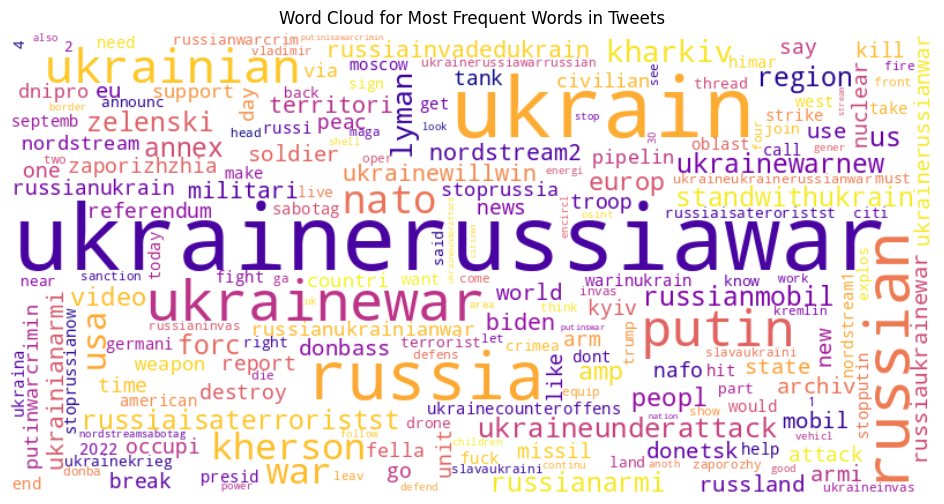

In [14]:
## Generate and display word cloud
# Count the occurrences of each word
all_words_list = all_words.split()
word_counts = Counter(all_words_list)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap = 'plasma')
wordcloud.generate_from_frequencies(word_counts)

# Display the generated image
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Most Frequent Words in Tweets')
plt.show()

In [15]:
## Entity recognition
# Extract all entities from all tweets
all_entities = [entity for tweet_info in tweet_information.values() for entity in tweet_info['Entities']]

# Find the top 5 entities based on frequency
top_entities = Counter(all_entities).most_common(5)

# Print the top 5 entities
print("Top 5 Entities:")
for entity, frequency in top_entities:
    print(f"{entity}: {frequency} times")

Top 5 Entities:
('russia', 'GPE'): 1777 times
('russian', 'NORP'): 1325 times
('nato', 'ORG'): 359 times
('putin', 'PERSON'): 237 times
('zelenski', 'PERSON'): 190 times


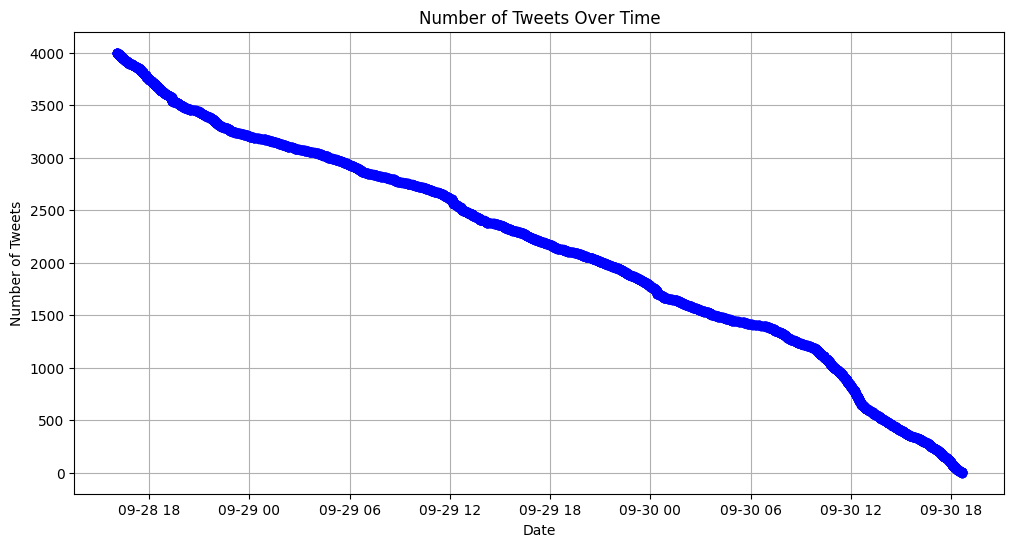

In [16]:
## Plotting the number of tweets over time
plt.figure(figsize=(12, 6))
plt.plot(tweet_times, range(len(tweet_times)), marker='o', linestyle='-', color='b')
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()